<a href="https://colab.research.google.com/github/mohitin/Bone-texture-characterization-using-CNN/blob/main/osteoporosis_detection_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Linking kaggle API and downloading dataset

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohitmeena123","key":"76128da786ff1a38363c8637f11321d6"}'}

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                       title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                        Data Science Job Salaries                            7KB  2022-06-15 08:59:12           6829        228  1.0              
surajjha101/bigbasket-entire-product-list-28k-datapoints  BigBasket Entire Product List (~28K datapoints)      6MB  2022-06-22 12:51:18           2258         97  1.0              
victorsoeiro/netflix-tv-shows-and-movies                  Netflix TV Shows and Movies                          2MB  2022-05-15 00:01:23          17049        493  1.0              
sameepvani/nasa-nearest-earth-objects                     NASA - Nearest Earth Objects         

In [ ]:
!kaggle datasets download -d chzpan/bone-lab

100% 6.99G/7.00G [03:07<00:00, 37.6MB/s]
100% 7.00G/7.00G [03:07<00:00, 40.1MB/s]


In [ ]:
!mkdir train

In [ ]:
!unzip bone-lab.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/trainset/C00055390069.png  
  inflating: train/trainset/C00055390070.png  
  inflating: train/trainset/C00055390071.png  
  inflating: train/trainset/C00055390072.png  
  inflating: train/trainset/C00055390073.png  
  inflating: train/trainset/C00055390074.png  
  inflating: train/trainset/C00055390075.png  
  inflating: train/trainset/C00055390076.png  
  inflating: train/trainset/C00055390077.png  
  inflating: train/trainset/C00055390078.png  
  inflating: train/trainset/C00055390079.png  
  inflating: train/trainset/C00055390080.png  
  inflating: train/trainset/C00055390081.png  
  inflating: train/trainset/C00055390082.png  
  inflating: train/trainset/C00055390083.png  
  inflating: train/trainset/C00055390084.png  
  inflating: train/trainset/C00055390085.png  
  inflating: train/trainset/C00055390086.png  
  inflating: train/trainset/C00055390087.png  
  inflating: train/trainset/C00055390088.png  
  inflati

## Data Preprocessing

Osteoporosis Detection using CNN and Keras by Mohsin
1. Importing the libraries
2. Training the set
3. Creating a model
4. Testing set by model COnv2D
5. Validating
6. Saving results to .csv
7. Dataset CT Scan of Bones Joints
8. Referring to the last work done
8. Improving the Estimated TIme Arrival and Lessening the Loss
9. Defining the region of interest of Vitamin D defficiency by preprocessing of the images
10. Concluded the Results

In [ ]:
import os
print(os.listdir("/content/train"))
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline
from PIL import Image
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
import random as rnd
import math

['trainset', 'roi']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


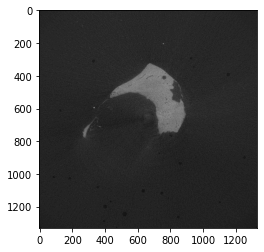

In [ ]:
path_img='/content/train/trainset/C00055300022.png'
img=Image.open(path_img)
plt.imshow(img,cmap='gray')

In [ ]:
IMG_WIDTH = 32
IMG_HEIGHT = 32
IMG_CHANNELS = 1
TRAIN_SIZE = 4000 
TRAIN_PATH = '/content/train/trainset/'
ROI_PATH = "/content/train/roi/"

In [ ]:
# Create useful helpers

def get_centers(dir_roi, resol=(2048, 2048)):
    ''' This function scans through the directory of the ROI files, reads the
        coordinates (in pixel) of the centers of all circular ROIs, then
        transforms them into relative coordinates (assumming image size 1x1) '''  

    img_id = []
    cx_pxl = []
    cy_pxl = []

    HEIGHT, WIDTH = resol
    
    # Get center coordinates of all sample images
    for dirpath, dirnames, files in os.walk(dir_roi):
        sample_id = os.path.split(dirpath)[1].split('.')[0]
        for file in files:
            img_id.append(sample_id + file[:4])
            cx_pxl.append(int(file[10:14]))
            cy_pxl.append(int(file[5:9]))

    df_roi = pd.DataFrame({'img_id': img_id,
                           'cx_pxl': cx_pxl,
                           'cy_pxl': cy_pxl},
                           columns = ['img_id', 'cx_pxl', 'cy_pxl'])
    df_roi['cx'] = df_roi.cx_pxl / float(WIDTH)
    df_roi['cy'] = df_roi.cy_pxl / float(HEIGHT)
            
    return df_roi

## cropped from (2048,2048) to (1330,1330)
def coord_transfm(df_roi_org, shifts=(359, 359), cropped_resol=(1330, 1330)):
    shift_x, shift_y = shifts
    HEIGHT, WIDTH = cropped_resol
    df_roi = df_roi_org.copy()
    df_roi.cx_pxl = df_roi.cx_pxl - shift_x
    df_roi.cy_pxl = df_roi.cy_pxl - shift_y
    df_roi.cx = df_roi.cx_pxl / float(WIDTH)
    df_roi.cy = df_roi.cy_pxl / float(HEIGHT)
    
    return df_roi 


def draw_roi(img_path, img_list, true_centers, pred_centers=None, 
             actual_R=1.5, actual_imgsize=16.38, current_resol=1330, 
             org_resol=2048, rows=1, cols=3, model_name="Model"):
    
    resize_ratio = current_resol / org_resol
    R = math.floor(current_resol * actual_R/(actual_imgsize*resize_ratio))
    
    plt.figure(figsize=(6*cols, 6*rows))
    
    for i, img_id in enumerate(img_list):
        plt.subplot(rows, cols, i+1)
        img = cv2.imread(TRAIN_PATH + img_id + '.png')
        cx = math.floor(true_centers[i, 0] * current_resol)
        cy = math.floor(true_centers[i, 1] * current_resol)        
        
        if pred_centers is not None:
            cx_pred = math.floor(pred_centers[i, 0] * current_resol) 
            cy_pred = math.floor(pred_centers[i, 1] * current_resol)
            img_mod = cv2.circle(img, (cx_pred, cy_pred), R, (0,0,255), 3)  # Mark the predicted center in blue
            img_mod = cv2.circle(img_mod, (cx_pred, cy_pred), round(R*0.05), (0,0,255), -1)  
            img_mod = cv2.circle(img_mod, (cx, cy), R, (255,0,0), 2)  # Mark the true center in red
            img_mod = cv2.circle(img_mod, (cx, cy), round(R*0.05), (255,0,0), -1)  

        else:
            img_mod = cv2.circle(img, (cx, cy), R, (255,0,0), 3)  # Mark the true center in red
            img_mod = cv2.circle(img_mod, (cx, cy), round(R*0.05), (255,0,0), -1)  

        plt.imshow(img_mod)
    
        if pred_centers is not None:
            plt.title("Vitamin D Deficiency Point  \n" + model_name + ": {}\nHuman annotted: {}"
                      .format(str((cx_pred, cy_pred)),
                              str((cx, cy))))
        else:
            plt.title("Vitamin D Deficiency Point: {}".format(str((cx, cy))))   
            

def mirror(df_imgs, flip_axis, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    
    pxl_cols = [col for col in df_imgs.columns if 'pxl' in col]
    num_imgs = df_imgs.shape[0]
    img_size = IMG_HEIGHT * IMG_WIDTH
    
    mat_images = df_imgs[pxl_cols].values
    mat_images = mat_images.reshape((num_imgs, IMG_HEIGHT, IMG_WIDTH))
    df_imgs_flip = df_imgs.copy()
    
    assert 'h' in flip_axis or 'v' in flip_axis, \
           "Flipping axis is not defined. Must be either 'horizontal' or 'vertical'."
    
    if 'h' in flip_axis:
        flipping = 1
        df_imgs_flip.img_id = df_imgs.img_id + 'hf'
        df_imgs_flip.cy = 1.0 - df_imgs.cy  
    elif 'v' in flip_axis:
        flipping = 2
        df_imgs_flip.img_id = df_imgs.img_id + 'vf'
        df_imgs_flip.cx = 1.0 - df_imgs.cx    
    
    # Flip images around the specified axis    
    mat_images_flip = np.flip(mat_images, flipping) \
                        .reshape((num_imgs, img_size))
    df_imgs_flip[pxl_cols] = mat_images_flip
    
    return df_imgs_flip

### Data Loading

In [ ]:
df_centers_org = get_centers(ROI_PATH).sort_values(by='img_id') \
                                     .reset_index(drop=True)
print(df_centers_org.head())
df_centers = coord_transfm(df_centers_org)
print(df_centers.head())

         img_id  cx_pxl  cy_pxl        cx       cy
0  C00055300022     859    1059  0.419434  0.51709
1  C00055300023     859    1059  0.419434  0.51709
2  C00055300024     859    1059  0.419434  0.51709
3  C00055300025     859    1059  0.419434  0.51709
4  C00055300026     859    1059  0.419434  0.51709
         img_id  cx_pxl  cy_pxl       cx        cy
0  C00055300022     500     700  0.37594  0.526316
1  C00055300023     500     700  0.37594  0.526316
2  C00055300024     500     700  0.37594  0.526316
3  C00055300025     500     700  0.37594  0.526316
4  C00055300026     500     700  0.37594  0.526316


In [ ]:
images = pd.Series(sorted(os.listdir(TRAIN_PATH)))
img_ids = images.str.split('.').str[0]
assert df_centers.img_id.equals(img_ids), "Image lists don't match"

Preprocessing of Images

In [ ]:

img_size = IMG_HEIGHT * IMG_WIDTH
mat_images = np.zeros((TRAIN_SIZE, img_size))
train_images = images.sample(TRAIN_SIZE, random_state=10)
train_img_ids = train_images.str.split('.').str[0]
df_train = pd.DataFrame(mat_images, 
                        columns=['pxl' + str(i) for i in range(img_size)])
df_train.insert(0, 'img_id', train_img_ids.values)
df_train = pd.merge(df_train, df_centers[['img_id', 'cx', 'cy']], 
                    on='img_id', validate="1:1")
print(df_train.head())
print(df_train.shape)

         img_id  pxl0  pxl1  pxl2  pxl3  pxl4  pxl5  pxl6  pxl7  pxl8  ...  \
0  C00055410076   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1  C00055900056   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2  C00055680038   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3  C00055310107   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4  C00055750077   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

   pxl1016  pxl1017  pxl1018  pxl1019  pxl1020  pxl1021  pxl1022  pxl1023  \
0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

         cx        cy  
0  0.380451  0.525564  
1  0.514286  0.48947

### Manual image preprocessing

In [ ]:
df_train_hflip = mirror(df_train, 'h')
df_train_vflip = mirror(df_train, 'v')

In [ ]:
## 4000+4000+4000
df_train = pd.concat([df_train, df_train_hflip, df_train_vflip],
                     ignore_index=True)
print("New dataframe's shape: {}".format(df_train.shape))
df_centers = df_train[['img_id', 'cx', 'cy']]

New dataframe's shape: (12000, 1027)


In [ ]:
## resizing to (1,32,32)
X = df_train.drop(columns=['img_id', 'cx', 'cy']) \
            .values.reshape((-1,IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS))
Y = df_train[['cx', 'cy']].values
IDs = df_train.img_id.values
X /= 255.0
print(X.shape)
print(Y.shape)

(12000, 32, 32, 1)
(12000, 2)


In [ ]:
# Free RAM space
del df_train, df_train_hflip, df_train_vflip, mat_images

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val, IDs_train, IDs_val = train_test_split(X, Y, IDs, test_size=0.10, random_state=1)
print("Trainset shape: {}".format(X_train.shape))
print("Validateset shape: {}".format(X_val.shape))

Trainset shape: (10800, 32, 32, 1)
Validateset shape: (1200, 32, 32, 1)


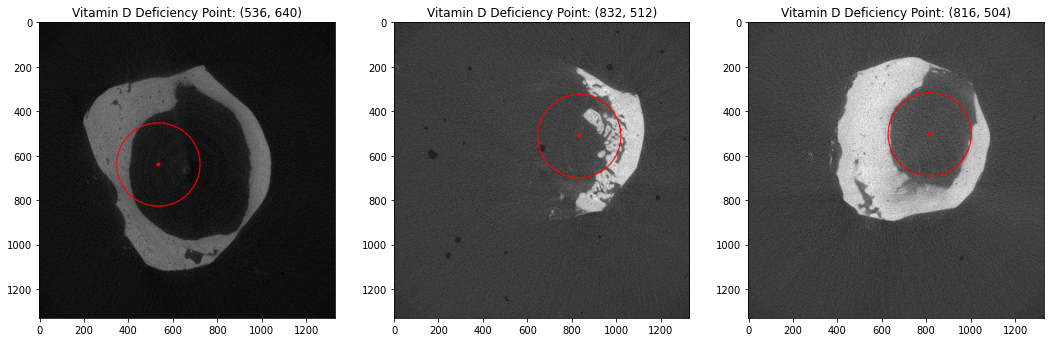

In [ ]:
import math 
import cv2
select_disp = df_centers.iloc[:TRAIN_SIZE].sample(n=3)
img_list = select_disp['img_id'].values
true_centers = select_disp[['cx', 'cy']].values
draw_roi(TRAIN_PATH, img_list, true_centers)

**Simple Convolutional Neural Network Model**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
cnn_model = Sequential()

cnn_model.add(Conv2D(filters = 32, kernel_size = (5,5), 
                     padding = 'Same', activation ='relu', 
                     input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))

cnn_model.add(Conv2D(filters = 32, kernel_size = (5,5),
                     padding = 'Same', activation ='relu'))

cnn_model.add(MaxPool2D(pool_size=(2,2)))
# cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3),
                 padding = 'Same', activation ='relu'))

cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3),
                     padding = 'Same', activation ='relu'))

cnn_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation = "relu"))
cnn_model.add(Dense(64, activation = "relu"))
# cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(2))

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        25632     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

In [ ]:
def mean_dist(y_pred, y_true):
    d = y_pred - y_true
    return tf.reduce_mean(tf.norm(d, axis=1))

In [ ]:
import tensorflow as tf
cnn_model.compile(loss=mean_dist, optimizer='adam')
cnn_model.fit(X_train, Y_train, batch_size=64, epochs=10)
cnn_model.save('/content/drive/MyDrive/Osteoporosis_detection/simple')

Epoch 1/10
169/169 [==============================] - 137s 799ms/step - loss: 0.1073
Epoch 2/10
169/169 [==============================] - 101s 601ms/step - loss: 0.1073
Epoch 3/10
169/169 [==============================] - 101s 598ms/step - loss: 0.1073
Epoch 4/10
169/169 [==============================] - 102s 601ms/step - loss: 0.1073
Epoch 5/10
169/169 [==============================] - 102s 602ms/step - loss: 0.1073
Epoch 6/10
169/169 [==============================] - 102s 601ms/step - loss: 0.1073
Epoch 7/10
169/169 [==============================] - 101s 600ms/step - loss: 0.1073
Epoch 8/10
169/169 [==============================] - 101s 598ms/step - loss: 0.1073
Epoch 9/10
169/169 [==============================] - 101s 599ms/step - loss: 0.1073
Epoch 10/10
169/169 [==============================] - 100s 594ms/step - loss: 0.1073


In [ ]:
cnn_scores_train = cnn_model.evaluate(X_train, Y_train)
print("Score on trainset: {}".format(cnn_scores_train))
cnn_scores_val = cnn_model.evaluate(X_val, Y_val)
print("Score on validate set: {}".format(cnn_scores_val))

338/338 [==============================] - 26s 77ms/step - loss: 0.1073
Score on trainset: 0.10731534659862518
38/38 [==============================] - 3s 72ms/step - loss: 0.1085
Score on validate set: 0.10847409814596176


In [ ]:
cnn_pred = cnn_model.predict(X_val, verbose=True)
cnn_results = pd.DataFrame(np.concatenate([cnn_pred, Y_val], axis=1), 
                          columns = ['cx_pred', 'cy_pred', 'cx', 'cy'])
cnn_results.insert(0, 'img_id', IDs_val)
print(cnn_results.head())

38/38 [==============================] - 3s 71ms/step
           img_id   cx_pred   cy_pred        cx        cy
0  C00056030075hf  0.499018  0.497281  0.498496  0.474436
1  C00056530071vf  0.499018  0.497281  0.488722  0.475188
2    C00055420077  0.499018  0.497281  0.674436  0.442105
3    C00055420127  0.499018  0.497281  0.682707  0.439098
4  C00055830112vf  0.499018  0.497281  0.598496  0.483459


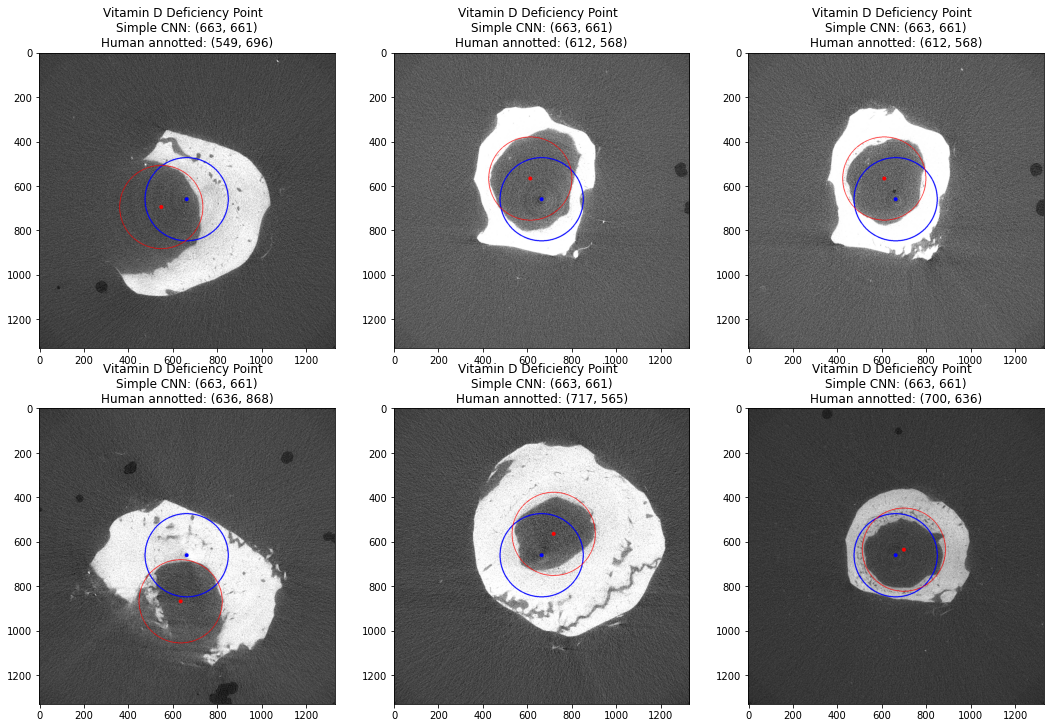

In [ ]:
orig = [img_id for img_id in cnn_results.img_id 
        if 'f' not in img_id]
orig_imgs = cnn_results[cnn_results.img_id.isin(orig)]
selt_imgs = orig_imgs.sample(n=6)
img_list = selt_imgs['img_id'].values
true_centers = selt_imgs[['cx', 'cy']].values
pred_centers = selt_imgs[['cx_pred', 'cy_pred']].values

draw_roi(TRAIN_PATH, img_list, true_centers, 
         pred_centers, rows=2, cols=3, model_name="Simple CNN")

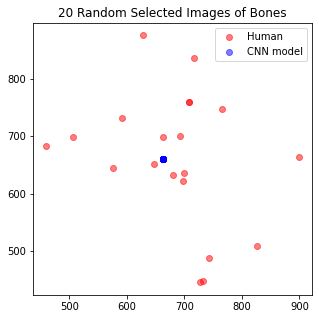

In [ ]:
selt_dots = orig_imgs.sample(n=20)
img_list = selt_dots['img_id'].values
true_centers = (selt_dots[['cx', 'cy']].values * 1330).astype(int)
pred_centers = (selt_dots[['cx_pred', 'cy_pred']].values * 1330).astype(int)

plt.figure(figsize = (5, 5))
plt.scatter(true_centers[:, 0], true_centers[:, 1], c='r', alpha=0.5, label='Human')
plt.scatter(pred_centers[:, 0], pred_centers[:, 1], c='b', alpha=0.5, label='CNN model')
plt.axis('equal')
plt.legend()
plt.title("20 Random Selected Images of Bones")
plt.show() 

In [ ]:
cnn_results.to_csv("/content/drive/MyDrive/Osteoporosis_detection/CNN1.csv")

## ResNet 50 model
**Convolutional Neural Network with Activation Functions**

In [ ]:
from keras import layers
from keras.layers import Input, Add, Activation, ZeroPadding2D, BatchNormalization, \
                         AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.initializers import glorot_uniform

In [ ]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), 
               padding = 'valid', name = conv_name_base + '2a', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1),
               padding = 'same', name = conv_name_base + '2b',
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), 
               padding = 'valid', name = conv_name_base + '2c', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name = bn_name_base + '2c')(X)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(F1, (1,1), strides = (s,s), name = conv_name_base + '2a',
               padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(F2, (f,f), strides = (1,1), name = conv_name_base + '2b',
               padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(F3, (1,1), strides = (1,1), name = conv_name_base + '2c',
               padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X) 
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'valid',
                        name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

In [ ]:
def ResNet50(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((1, 1))(X_input) # mod (3,3) -> (1,1)
    X = Conv2D(64, (3, 3), strides=(1, 1), name='conv1', # mod (7,7) -> (3,3); (2,2) -> (1,1)
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f=3, filters=[64, 64, 256], 
                            stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    X = convolutional_block(X, f=3, filters=[128,128,512],
                            stage=3, block='a', s=2) 
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block='b')
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block='c')
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block='d')
    X = convolutional_block(X, f=3, filters=[256,256,1024],
                            stage=4, block='a', s=2) 
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='b')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='c')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='d')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='e')
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block='f')
    X = convolutional_block(X, f=3, filters=[512,512,2048],
                            stage=5, block='a', s=2) 
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block='b')
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block='c')
    X = AveragePooling2D((2,2), name='avg_pool')(X)
    X = Flatten()(X)
    # X = Dense(1024, name='fc_1024', kernel_initializer=glorot_uniform(seed=0))(X)  # add an extra dense layer
    # X = Dense(64, name='fc_64', kernel_initializer=glorot_uniform(seed=0))(X)  # add an extra dense layer
    X = Dense(2, name='fc_outputs', kernel_initializer=glorot_uniform(seed=0))(X)
    model = Model(inputs = X_input, outputs = X, name = 'Conv2')
    return model

In [ ]:
ResNet_model = ResNet50(input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
ResNet_model.summary()

Model: "Conv2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 34, 34, 1)   0           ['input_5[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 32, 32, 64)   640         ['zero_padding2d_4[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1[0][0]']              

In [ ]:
#accuracy=tf.keras.metrics.Accuracy(name='accuracy', dtype=None)
ResNet_model.compile(loss=mean_dist, optimizer='adam')
ResNet_model.fit(X_train, Y_train, batch_size=64, epochs=10)
cnn_model.save('/content/drive/MyDrive/Osteoporosis_detection/')

Epoch 1/10
169/169 [==============================] - 1489s 9s/step - loss: 0.5917
Epoch 2/10
169/169 [==============================] - 1501s 9s/step - loss: 0.3595
Epoch 3/10
169/169 [==============================] - 1522s 9s/step - loss: 0.1686
Epoch 4/10
169/169 [==============================] - 1521s 9s/step - loss: 0.1093
Epoch 5/10
169/169 [==============================] - 1500s 9s/step - loss: 0.1073
Epoch 6/10
169/169 [==============================] - 1501s 9s/step - loss: 0.1073
Epoch 7/10
169/169 [==============================] - 1518s 9s/step - loss: 0.1073
Epoch 8/10
169/169 [==============================] - 1546s 9s/step - loss: 0.1073
Epoch 9/10
169/169 [==============================] - 1531s 9s/step - loss: 0.1073
Epoch 10/10
169/169 [==============================] - 1547s 9s/step - loss: 0.1073


In [ ]:
ResNet_scores_train = ResNet_model.evaluate(X_train, Y_train, batch_size=128)
print("Score on trainset: {}".format(ResNet_scores_train))
ResNet_scores_val = ResNet_model.evaluate(X_val, Y_val)
print("Score on validate set: {}".format(ResNet_scores_val))

85/85 [==============================] - 137s 2s/step - loss: 0.1072
Score on trainset: 0.10724816471338272
38/38 [==============================] - 16s 414ms/step - loss: 0.1085
Score on validate set: 0.10848762840032578


In [ ]:
ResNet_pred = ResNet_model.predict(X_val, verbose=True)
ResNet_results = pd.DataFrame(np.concatenate([ResNet_pred, Y_val], axis=1), 
                              columns = ['cx_pred', 'cy_pred', 'cx', 'cy'])
ResNet_results.insert(0, 'img_id', IDs_val)
print(ResNet_results.head())

38/38 [==============================] - 17s 417ms/step
           img_id   cx_pred   cy_pred        cx        cy
0  C00056030075hf  0.495236  0.498929  0.498496  0.474436
1  C00056530071vf  0.495236  0.498929  0.488722  0.475188
2    C00055420077  0.495236  0.498929  0.674436  0.442105
3    C00055420127  0.495236  0.498929  0.682707  0.439098
4  C00055830112vf  0.495236  0.498929  0.598496  0.483459


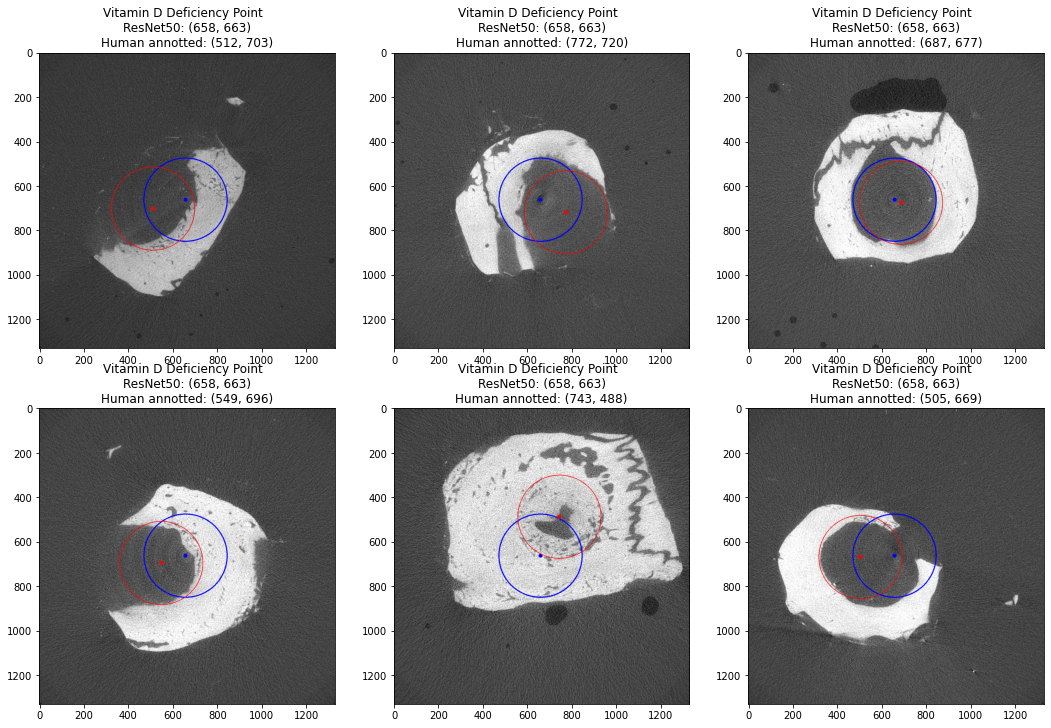

In [ ]:
orig = [img_id for img_id in ResNet_results.img_id 
        if 'f' not in img_id]
orig_imgs = ResNet_results[ResNet_results.img_id.isin(orig)]
selt_imgs = orig_imgs.sample(n=6)
img_list = selt_imgs['img_id'].values
true_centers = selt_imgs[['cx', 'cy']].values
pred_centers = selt_imgs[['cx_pred', 'cy_pred']].values

draw_roi(TRAIN_PATH, img_list, true_centers, pred_centers, 
         rows=2, cols=3, model_name="ResNet50")

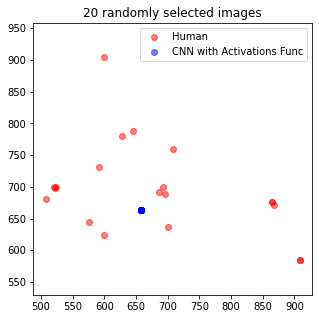

In [ ]:
selt_dots = orig_imgs.sample(n=20)
img_list = selt_dots['img_id'].values
true_centers = (selt_dots[['cx', 'cy']].values * 1330).astype(int)
pred_centers = (selt_dots[['cx_pred', 'cy_pred']].values * 1330).astype(int)

plt.figure(figsize = (5, 5))
plt.scatter(true_centers[:, 0], true_centers[:, 1], c='r', alpha=0.5, label='Human')
plt.scatter(pred_centers[:, 0], pred_centers[:, 1], c='b', alpha=0.5, label='CNN with Activations Func')
plt.axis('equal')
plt.legend()
plt.title("20 randomly selected images")
plt.show() 

In [ ]:
# Save results
ResNet_results.to_csv("/content/drive/MyDrive/Osteoporosis_detection/CNN2_results.csv")